In [210]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
def gaussian_pyramid(image):
    template_options = []
    #Creat Gaussian Scaled Images
    layer = image.copy()
    for x in range(5):
        layer = cv2.pyrDown(layer)
        template_options.append(layer)
        
    return template_options
    
def random_colour():
    return (random.randint(0, 150), random.randint(0, 150), random.randint(0, 150))


def template_match(target, template_options, key):
    target_gray = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    colour = random_colour()
    text_coord = []
    for template_option in template_options:
        h, w = template_option.shape
        threshold = 0.95
        res = cv2.matchTemplate(target_gray, template_option, cv2.TM_CCOEFF_NORMED)
        loc = np.where(res >= threshold)
        
        
        for pt in zip(*loc[::-1]):
            text_coord.append(pt)
            
            cv2.rectangle(target, pt, (pt[0] + w, pt[1] + h), colour, 2)
    #plt.imshow(target)
    
    return target, text_coord

def temp_matching(test_image, template_dict):
    target = test_image
    keys = template_dict.keys()
    text_coords = []
    
    for key in keys:
        template_options = template_dict[key]
        target, text_coord = template_match(target, template_options, key)
        
        
        text_coords.append(text_coord)
    #text_indexes = [x for x in range(len(text_coords)) if text_coords[x]]    
   # text_coords = [x for x in text_coords if x]
    #print(text_coords)
    
    for index in range(len(text_coords)):
        #print(text_coords[index])
        
        if text_coords[index]:
            cv2.putText(img=target, text=list(keys)[index], org=(text_coords[index][0][0]-20,text_coords[index][0][1]-10), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.5, color=(0, 0, 0),thickness=1)
            
    return target
    
    

In [211]:
# Load the template image and the target image
target = cv2.imread('Task2Dataset/TestWithoutRotations/images/test_image_12.png')



#Make Template Classes
directory_template = "Task2Dataset/Training/png"
class_list = []
template_dict = dict()

for filename in os.listdir(directory_template):
    f = os.path.join(directory, filename)
    
    # checking if it is a file
    class_name = f.partition("-")[2].partition(".")[0]
    template_pyr = gaussian_pyramid(cv2.imread(f, cv2.IMREAD_GRAYSCALE))
    template_dict[class_name] = template_pyr

#Testing Classes
directory_test = "Task2Dataset/TestWithoutRotations/images"
test_images_numbers = []
image_results = []
results = []


for filename in os.listdir(directory_test):
    f = os.path.join(directory_test, filename)
    image_number = f.partition("_")[2].partition("_")[2].partition(".")[0]
    test_images_numbers.append(image_number)
    image_results.append(temp_matching(cv2.imread(f), template_dict))






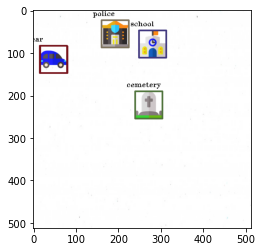

1


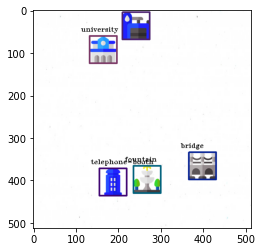

1


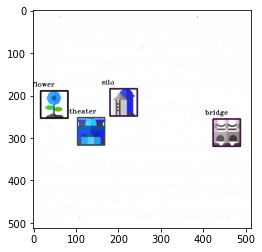

1


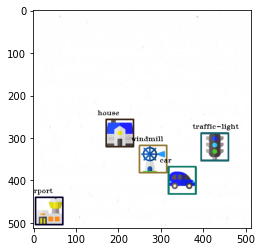

1


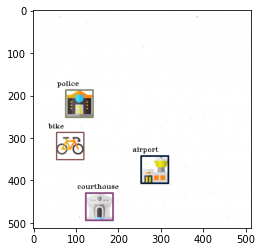

1


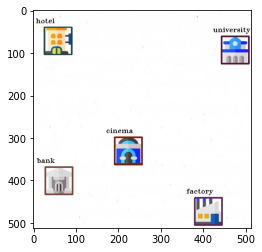

1


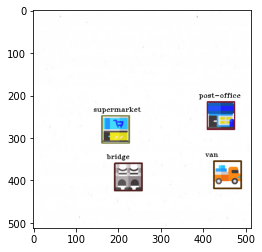

1


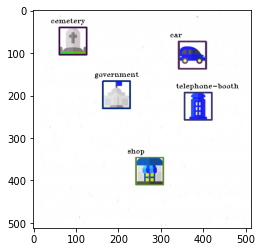

1


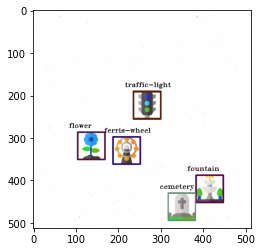

1


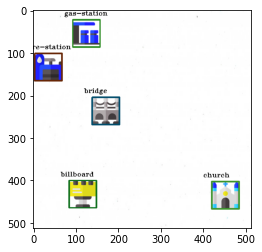

1


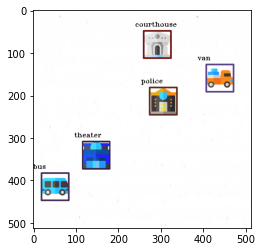

1


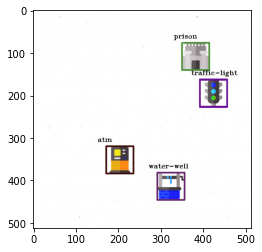

1


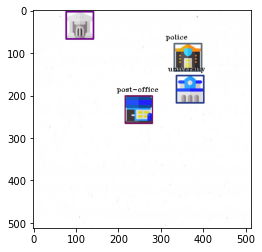

1


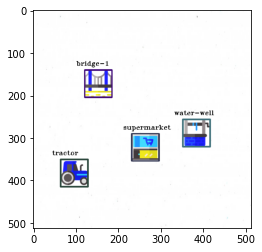

1


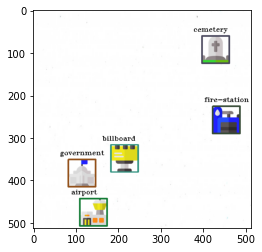

1


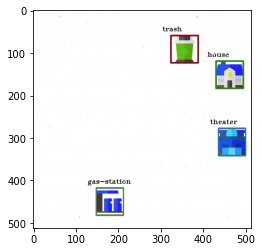

1


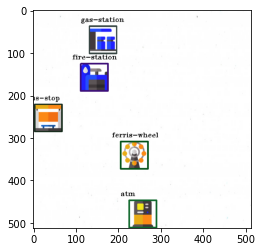

1


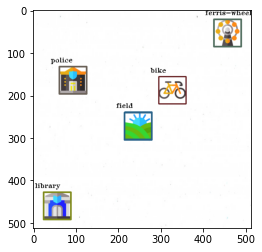

1


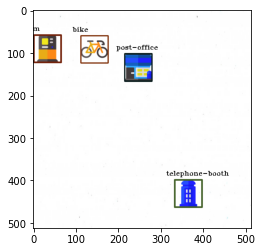

1


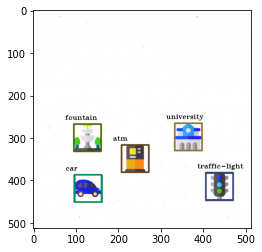

1


In [212]:
for image in image_results:
    plt.figure()
    plt.imshow(image)
    plt.show()
    results.append(input())

In [213]:
results

['1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1']